In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from imgaug import augmenters as iaa
import numpy as np

In [19]:
# Number of Residual blocks in Residual Layer i
res_block_nums = [2, 2, 4, 1]
# Number of channels in Residual Layer i
channel_nums = [48, 96, 192, 384]
# Average pool kernel size
avg_pool_kernel_size = 4

In [21]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, channel_nums[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channel_nums[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, channel_nums[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, channel_nums[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(channel_nums[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model_reference():
    return ResNet(BasicBlock, [3, 4, 5, 3])

#returns our ResNet architecture
def project1_model():
    return ResNet(BasicBlock, res_block_nums)

In [24]:
resnet = project1_model().cuda()
summary(resnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 48, 32, 32]          27,648
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 48, 32, 32]          20,736
       BatchNorm2d-6           [-1, 48, 32, 32]              96
            Conv2d-7           [-1, 48, 32, 32]           3,072
       BatchNorm2d-8           [-1, 48, 32, 32]              96
        BasicBlock-9           [-1, 48, 32, 32]               0
           Conv2d-10           [-1, 48, 32, 32]          20,736
      BatchNorm2d-11           [-1, 48, 32, 32]              96
           Conv2d-12           [-1, 48, 32, 32]          20,736
      BatchNorm2d-13           [-1, 48, 32, 32]              96
       BasicBlock-14           [-1, 48,

In [25]:
from imgaug.augmenters.contrast import GammaContrast
from imgaug.augmenters.blur import GaussianBlur
import numpy as np
from imgaug import augmenters as iaa

#run on gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#EPOCH = 50   
BATCH_SIZE = 256      
LR = 0.1        #learning rate

#data transform

#training transform with imgaug lib:
transform_train_img =  transforms.Compose([
                                           transforms.RandomCrop(32, padding=4),  #do zero padding and then crop the image randomly into 32x32 picture
                                           transforms.RandomHorizontalFlip(),  #50% flip the image horizontally 
                                           np.asarray,
    iaa.Sequential([
                    iaa.Sometimes(0.1,iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))),#add gaussian noise
                    iaa.Sometimes(0.1, iaa.GammaContrast((0.5, 2.0))),# 2 contrast enhancing techniques
                    iaa.Sometimes(0.1, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
    ]).augment_image,
    np.copy,
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #normalization
])

#testing transform
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])






#dataset loading
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_img) 
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainDataLoader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
testDataLoader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

dataloaders = {'train': trainDataLoader, 'val': testDataLoader}
#resnet =  resnet().to(device)
resnet.eval()
corrects = 0


for batch_idx, (inputs,labels) in enumerate(testDataLoader, 1):
  with torch.set_grad_enabled(False):
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = resnet(inputs)
    _, preds = torch.max(outputs,1)    
  corrects += torch.sum(preds == labels.data)
print(corrects.float() / len(testDataLoader.dataset))

criterion = nn.CrossEntropyLoss()  

#SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)#*0.5 every 15 steps


cur_lr_list = []
save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]} 

Files already downloaded and verified
Files already downloaded and verified
tensor(0.1000, device='cuda:0')


In [27]:
for epoch in range(200):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            resnet.train()  # Set model to training mode
        else:
            resnet.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = resnet(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()


            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
            
        
        
        if phase == 'train':
                    scheduler.step()  #update learning rate
                    cur_lr=optimizer.param_groups[-1]['lr']
                    cur_lr_list.append(cur_lr)

        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        # pretty print
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:0.53 -- Acc:81.46
Epoch:0 -- Phase:val -- Loss:0.62 -- Acc:79.48
Epoch:1 -- Phase:train -- Loss:0.50 -- Acc:82.58
Epoch:1 -- Phase:val -- Loss:0.65 -- Acc:78.70
Epoch:2 -- Phase:train -- Loss:0.49 -- Acc:83.15
Epoch:2 -- Phase:val -- Loss:0.58 -- Acc:80.82
Epoch:3 -- Phase:train -- Loss:0.46 -- Acc:84.07
Epoch:3 -- Phase:val -- Loss:0.54 -- Acc:82.59
Epoch:4 -- Phase:train -- Loss:0.44 -- Acc:84.59
Epoch:4 -- Phase:val -- Loss:0.66 -- Acc:78.74
Epoch:5 -- Phase:train -- Loss:0.43 -- Acc:85.00
Epoch:5 -- Phase:val -- Loss:0.47 -- Acc:84.26
Epoch:6 -- Phase:train -- Loss:0.41 -- Acc:85.76
Epoch:6 -- Phase:val -- Loss:0.49 -- Acc:83.82
Epoch:7 -- Phase:train -- Loss:0.41 -- Acc:86.08
Epoch:7 -- Phase:val -- Loss:0.65 -- Acc:79.22
Epoch:8 -- Phase:train -- Loss:0.31 -- Acc:89.41
Epoch:8 -- Phase:val -- Loss:0.34 -- Acc:88.40
Epoch:9 -- Phase:train -- Loss:0.28 -- Acc:90.36
Epoch:9 -- Phase:val -- Loss:0.35 -- Acc:88.33
Epoch:10 -- Phase:train -- Loss:0.28 -- 

In [29]:
torch.save(resnet.state_dict(),'./project1_model.pt')#save the final model parameters

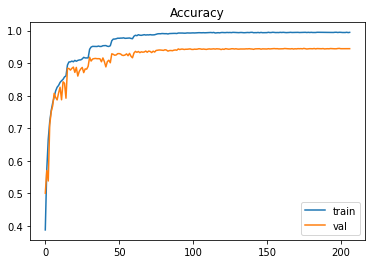

In [30]:
#Accuracy curves
for i in range(len(save_acc['train'])):
    save_acc['train'][i]=save_acc['train'][i].cpu().numpy()
    save_acc['val'][i]=save_acc['val'][i].cpu().numpy()
    #save_acc['train'][i]=save_acc['train'][i]
    #save_acc['val'][i]=save_acc['val'][i]
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")
plt.savefig('./graph/acc.jpg')



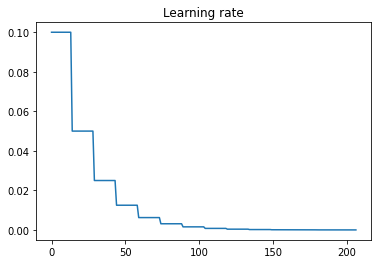

In [31]:
#learning rate curve
x_list = list(range(len(cur_lr_list)))
plt.plot(x_list, cur_lr_list)
plt.title("Learning rate")
plt.savefig('./graph/LR.jpg')
plt.show()

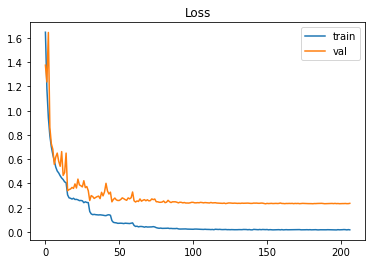

In [32]:
#loss curves
for i in range(len(save_loss['train'])):
    save_loss['train'][i]=save_loss['train'][i]
    save_loss['val'][i]=save_loss['val'][i]
plt.plot(save_loss['train'])
plt.plot(save_loss['val'])
plt.legend(["train", "val"])
plt.title("Loss")
plt.savefig('./graph/loss.jpg')

End of the script.
References included in the project report.

------------------------